# Anomaly Detection Using Density Estimation
**Dataset:** Gas Sensor Array Drift Dataset (UCI)
Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset)

This notebook demonstrates unsupervised anomaly detection using density estimation methods on industrial sensor data.

Methods used:

- Gaussian Mixture Model (GMM)
- Kernel Density Estimation (KDE)

Anomalies are defined as samples with low density (lowest 5%).

**Skills demonstrated:** Density estimation, anomaly scoring, threshold selection, unsupervised anomaly explanation, high-dimensional visualization.

Visualization is used for exploratory analysis and model interpretation.


In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
import zipfile
import os
import warnings
warnings.filterwarnings("ignore")

# Step 1.1: Set paths
ZIP_FILE_PATH = "/content/gas+sensor+array+drift+dataset.zip"  # Uploaded file in Colab
EXTRACT_DIR = "/content/data/gas_sensor"
FIGURES_DIR = "/content/figures"

os.makedirs(EXTRACT_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [ ]:
# Step 2: Extract ZIP file
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

# Check what was extracted
print("Files in extract directory:", os.listdir(EXTRACT_DIR))


Files in extract directory: ['Dataset']


In [ ]:
# Step 3: Load all .dat batch files from subfolders
data_list = []

for root, dirs, files in os.walk(EXTRACT_DIR):
    for file in files:
        if file.endswith(".dat"):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path, delim_whitespace=True, header=None)
            data_list.append(df)

# Combine all batches
raw_data = pd.concat(data_list, ignore_index=True)
print("Raw data shape:", raw_data.shape)
raw_data.head()


Raw data shape: (13910, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,5,1:11977.037100,2:2.946364,3:2.490357,4:3.283046,5:8.131875,6:-1.657614,7:-2.670484,8:-11.795855,9:87.695700,...,119:-2.423573,120:-7.170650,121:8644.852000,122:2.833984,123:2.063476,124:3.004145,125:5.358905,126:-1.387367,127:-2.142489,128:-6.199217
1,4,1:21234.289600,2:4.223873,3:4.758852,4:6.588781,5:10.873780,6:-3.145160,7:-4.474324,8:-14.394855,9:33730.917500,...,119:-7.378631,120:-14.347134,121:18538.251000,122:4.372579,123:6.203024,124:11.380773,125:14.663342,126:-4.112915,127:-6.365457,128:-12.539143
2,5,1:13190.525800,2:3.139281,3:2.743704,4:3.603623,5:8.335304,6:-1.807550,7:-2.781656,8:-9.959871,9:32443.260200,...,119:-2.658821,120:-7.089700,121:8914.200200,122:2.809080,123:2.110775,124:3.110680,125:5.728957,126:-1.459713,127:-2.201871,128:-6.398889
3,4,1:15803.785100,2:3.500589,3:3.375378,4:4.549901,5:8.983869,6:-2.278670,7:-3.915519,8:-11.937122,9:29541.839800,...,119:-7.464786,120:-16.511583,121:18378.394000,122:4.215725,123:6.140109,124:11.200258,125:14.870893,126:-4.010406,127:-6.422811,128:-12.380150
4,5,1:16342.678700,2:3.497127,3:3.393961,4:4.303557,5:8.713730,6:-2.173565,7:-3.373084,8:-11.741132,9:38268.074700,...,119:-2.437892,120:-6.492106,121:8903.250400,122:2.907423,123:2.041402,124:3.037082,125:5.453722,126:-1.451056,127:-2.163901,128:-6.076439


In [ ]:
# Step 4: Select sensor readings (columns 2+)
sensor_data = raw_data.iloc[:, 2:]
print("Sensor data shape:", sensor_data.shape)
sensor_data.head()


Sensor data shape: (13910, 127)


,2,3,4,5,6,7,8,9,10,11,...,119,120,121,122,123,124,125,126,127,128
0,2:2.946364,3:2.490357,4:3.283046,5:8.131875,6:-1.657614,7:-2.670484,8:-11.795855,9:87.695700,10:1.159134,11:0.197929,...,119:-2.423573,120:-7.170650,121:8644.852000,122:2.833984,123:2.063476,124:3.004145,125:5.358905,126:-1.387367,127:-2.142489,128:-6.199217
1,2:4.223873,3:4.758852,4:6.588781,5:10.873780,6:-3.145160,7:-4.474324,8:-14.394855,9:33730.917500,10:7.440933,11:9.210292,...,119:-7.378631,120:-14.347134,121:18538.251000,122:4.372579,123:6.203024,124:11.380773,125:14.663342,126:-4.112915,127:-6.365457,128:-12.539143
2,2:3.139281,3:2.743704,4:3.603623,5:8.335304,6:-1.807550,7:-2.781656,8:-9.959871,9:32443.260200,10:5.922316,11:7.244470,...,119:-2.658821,120:-7.089700,121:8914.200200,122:2.809080,123:2.110775,124:3.110680,125:5.728957,126:-1.459713,127:-2.201871,128:-6.398889
3,2:3.500589,3:3.375378,4:4.549901,5:8.983869,6:-2.278670,7:-3.915519,8:-11.937122,9:29541.839800,10:3.865898,11:8.606988,...,119:-7.464786,120:-16.511583,121:18378.394000,122:4.215725,123:6.140109,124:11.200258,125:14.870893,126:-4.010406,127:-6.422811,128:-12.380150
4,2:3.497127,3:3.393961,4:4.303557,5:8.713730,6:-2.173565,7:-3.373084,8:-11.741132,9:38268.074700,10:6.157833,11:8.455788,...,119:-2.437892,120:-6.492106,121:8903.250400,122:2.907423,123:2.041402,124:3.037082,125:5.453722,126:-1.451056,127:-2.163901,128:-6.076439


In [ ]:
# Step 5: Parse 'index:value' strings to numeric
def extract_value(x):
    try:
        return float(x.split(":")[1])
    except:
        return np.nan

sensor_data_numeric = sensor_data.applymap(extract_value)
print("Shape after parsing numeric values:", sensor_data_numeric.shape)
print("Total missing values:", sensor_data_numeric.isna().sum().sum())
sensor_data_numeric.head()


Shape after parsing numeric values: (13910, 127)
Total missing values: 0


,2,3,4,5,6,7,8,9,10,11,...,119,120,121,122,123,124,125,126,127,128
0,2.946364,2.490357,3.283046,8.131875,-1.657614,-2.670484,-11.795855,87.6957,1.159134,0.197929,...,-2.423573,-7.170650,8644.8520,2.833984,2.063476,3.004145,5.358905,-1.387367,-2.142489,-6.199217
1,4.223873,4.758852,6.588781,10.873780,-3.145160,-4.474324,-14.394855,33730.9175,7.440933,9.210292,...,-7.378631,-14.347134,18538.2510,4.372579,6.203024,11.380773,14.663342,-4.112915,-6.365457,-12.539143
2,3.139281,2.743704,3.603623,8.335304,-1.807550,-2.781656,-9.959871,32443.2602,5.922316,7.244470,...,-2.658821,-7.089700,8914.2002,2.809080,2.110775,3.110680,5.728957,-1.459713,-2.201871,-6.398889
3,3.500589,3.375378,4.549901,8.983869,-2.278670,-3.915519,-11.937122,29541.8398,3.865898,8.606988,...,-7.464786,-16.511583,18378.3940,4.215725,6.140109,11.200258,14.870893,-4.010406,-6.422811,-12.380150
4,3.497127,3.393961,4.303557,8.713730,-2.173565,-3.373084,-11.741132,38268.0747,6.157833,8.455788,...,-2.437892,-6.492106,8903.2504,2.907423,2.041402,3.037082,5.453722,-1.451056,-2.163901,-6.076439


In [ ]:
# Step 6: Drop mostly empty columns and fill remaining NaNs
threshold = 0.5  # drop columns with >50% NaN
sensor_data_clean = sensor_data_numeric.loc[:, sensor_data_numeric.isna().mean() < threshold]

# Fill remaining NaNs with median
sensor_data_clean = sensor_data_clean.fillna(sensor_data_clean.median())

print("Shape after cleaning:", sensor_data_clean.shape)
print("Total missing values remaining:", sensor_data_clean.isna().sum().sum())
sensor_data_clean.head()


Shape after cleaning: (13910, 127)
Total missing values remaining: 0


,2,3,4,5,6,7,8,9,10,11,...,119,120,121,122,123,124,125,126,127,128
0,2.946364,2.490357,3.283046,8.131875,-1.657614,-2.670484,-11.795855,87.6957,1.159134,0.197929,...,-2.423573,-7.170650,8644.8520,2.833984,2.063476,3.004145,5.358905,-1.387367,-2.142489,-6.199217
1,4.223873,4.758852,6.588781,10.873780,-3.145160,-4.474324,-14.394855,33730.9175,7.440933,9.210292,...,-7.378631,-14.347134,18538.2510,4.372579,6.203024,11.380773,14.663342,-4.112915,-6.365457,-12.539143
2,3.139281,2.743704,3.603623,8.335304,-1.807550,-2.781656,-9.959871,32443.2602,5.922316,7.244470,...,-2.658821,-7.089700,8914.2002,2.809080,2.110775,3.110680,5.728957,-1.459713,-2.201871,-6.398889
3,3.500589,3.375378,4.549901,8.983869,-2.278670,-3.915519,-11.937122,29541.8398,3.865898,8.606988,...,-7.464786,-16.511583,18378.3940,4.215725,6.140109,11.200258,14.870893,-4.010406,-6.422811,-12.380150
4,3.497127,3.393961,4.303557,8.713730,-2.173565,-3.373084,-11.741132,38268.0747,6.157833,8.455788,...,-2.437892,-6.492106,8903.2504,2.907423,2.041402,3.037082,5.453722,-1.451056,-2.163901,-6.076439


In [ ]:
# Step 7: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sensor_data_clean)
print("Standardization done. Shape:", X_scaled.shape)


Standardization done. Shape: (13910, 127)


In [ ]:
# Step 8: Gaussian Mixture Model anomaly detection
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=42)
gmm.fit(X_scaled)

gmm_scores = gmm.score_samples(X_scaled)  # log-likelihood
threshold_gmm = np.percentile(gmm_scores, 5)  # bottom 5%
gmm_anomalies = sensor_data_clean[gmm_scores < threshold_gmm]

print("Number of GMM anomalies detected:", len(gmm_anomalies))


Number of GMM anomalies detected: 696


In [ ]:
# Step 9: Kernel Density Estimation anomaly detection
kde = KernelDensity(kernel="gaussian", bandwidth=0.5)
kde.fit(X_scaled)

kde_scores = kde.score_samples(X_scaled)
threshold_kde = np.percentile(kde_scores, 5)  # bottom 5%
kde_anomalies = sensor_data_clean[kde_scores < threshold_kde]

print("Number of KDE anomalies detected:", len(kde_anomalies))


Number of KDE anomalies detected: 696


> Note: Anomalies are defined as samples with the lowest 5% density.
> This is a rule-based unsupervised method; scores may not generalize to other datasets.


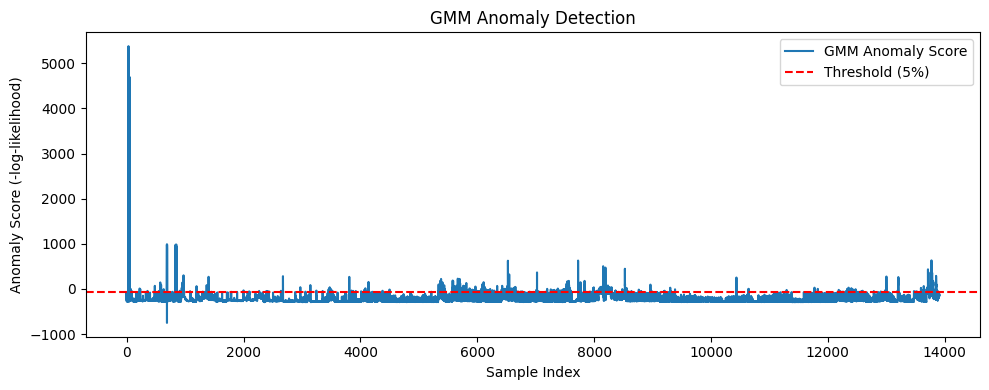

In [ ]:
# Step 10: Plot GMM anomaly scores
plt.figure(figsize=(10,4))
plt.plot(-gmm_scores, label="GMM Anomaly Score")
plt.axhline(-threshold_gmm, color='red', linestyle='--', label="Threshold (5%)")
plt.xlabel("Sample Index")
plt.ylabel("Anomaly Score (-log-likelihood)")
plt.title("GMM Anomaly Detection")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "gmm_anomaly_scores.png"), dpi=150)
plt.show()


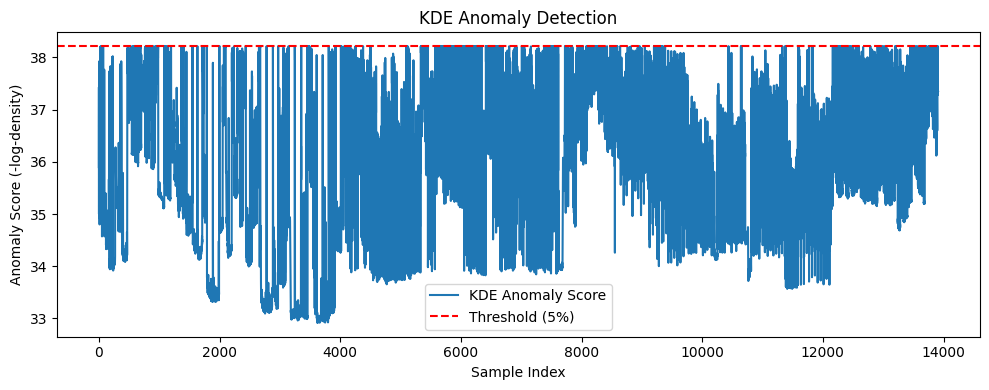

In [ ]:
# Step 11: Plot KDE anomaly scores
plt.figure(figsize=(10,4))
plt.plot(-kde_scores, label="KDE Anomaly Score")
plt.axhline(-threshold_kde, color='red', linestyle='--', label="Threshold (5%)")
plt.xlabel("Sample Index")
plt.ylabel("Anomaly Score (-log-density)")
plt.title("KDE Anomaly Detection")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "kde_anomaly_scores.png"), dpi=150)
plt.show()


## Summary & Insights

- Sensor data loaded from ZIP and parsed from 'index:value' format.
- Columns with mostly missing values removed; remaining NaNs filled with median.
- Features standardized using StandardScaler.
- Unsupervised anomaly detection performed using:
  - Gaussian Mixture Model (GMM)
  - Kernel Density Estimation (KDE)
- Anomalies defined as samples in the lowest 5% density.
- Number of anomalies detected:
  - GMM: 696 samples
  - KDE: 696 samples
- Insights:
  - Anomalies indicate sensor drift, faulty measurements, or unexpected chemical concentrations.
  - GMM provides probabilistic log-likelihood scores; KDE captures local density variations.
  - Visual inspection shows anomalies appear sporadically across the dataset.
- Skills demonstrated:
  - Advanced data parsing and cleaning
  - Feature scaling
  - Density-based anomaly detection
  - Visualization for model interpretation
  - Unsupervised ML workflow applicable to IoT, sensor monitoring, and fraud detection.
